##### Sequence-to-sequence modeling for Bitcoin  

The plan is to use an encoder-decoder model to try to predict daily returns of Bitcoin.   

 - Input Sequence: rolling 7 weeks of Bitcoin prices, hourly tickers  
 - Output Sequence 1: previous daily returns for Bitcoin, over the entire input dataset  
 - Output Sequence 2: next 30 day returns for Bitcoin  
 
I am going to use an RNN-LSTM model (similar to Palangi *et al* 2016) for this and run two different approaches:  

  1. We wil take the input sequence and try to map this to Output Seq 2, i.e. a direct prediction model.  
  2. We will then adapt this using the sentence-embedding approach used by Zhu *et al* (2015) where the used two decoder sequences to develop a semantic model for sentences. My hope is that this will lead to a richer representation.

In some ways, this is a slight cheat... because I am using a time period that the model is observing as Output Sequence 1. However, I see a couple of advantages. Firstly, the previous 30 day returns (Output Seq 1) are not the same as the hourly ticker data that the model observes. So there is some abstraction, which treats this more as a machine translation problem than a specific prediction problem. Secondly, by doing so I hope to exaggerate patterns in the hourly tickers which are predictive of returns. Also, there are no real "rules" for how I represent this problem. Looking at the problem in a slightly different way may just be surprising. Finally, by running both experiments above, I can directly compare the performance of the two methods and so, there are some quantitative controls here.  

## Data preparation  

Bitcoin is currently in a massive slump, following the highs of 2017. However, this isn't the first time that Bitcoin has gone through a large surge and pullback, with similar patterns observed over the past few years.

I have previously downloaded Bitcoin price data from Poloniex, going back to 2015. I will use all of the BTC/USDT ticker data in this initial run through. The data will be preapred as follows:  

  - Input sequence: 7 week period of Hourly Tickers (24 x 7 x 7 = 1176 hourly price points). Each input dataset will be offset by 1 day. This will yield largely overlapping training sets, but reflects the desire to review portfolio options on a daily basis.  
  - Output sequence 1: previous daily returns for the input dataset. These will be calculated as daily returns (i.e. price day(n) -> price day(n+1))  
  - Output sequence 2: calcluate the periodic returns for the next 30 days (i.e. the return from day(n) -> day(n+1), day(n) -> day(n+2), ..., day(n) -> day(n+14)). 

In [1]:
library(ggplot2)
library(data.table)
library(keras)
install_keras()

data_file_pattern <- "../Data/%s/poloniex/PoloniexChartData_USDT_BTC.csv"
raw_data <- rbindlist(
    lapply(2015:2018, function (yr) {
        tmp <- fread(sprintf(data_file_pattern, yr))
        tmp[, Datestamp := as.POSIXct(Datestamp)]
        tmp[, HourlyStamp := as.POSIXct(strftime(Datestamp, format = "%Y-%m-%d %H:00:00"))]
        tmp[, DailyStamp := as.POSIXct(strftime(Datestamp, format = "%Y-%m-%d"))]
        tmp[, HourlyMaxClose := max(close), by = "HourlyStamp"]
        return(tmp)
    })
)

str(raw_data)
head(raw_data[order(date, decreasing = FALSE)], n = 10)

Creating virtualenv for TensorFlow at  ~/.virtualenvs/r-tensorflow 
Installing TensorFlow ...

Installation complete.

Classes ‘data.table’ and 'data.frame':	119006 obs. of  12 variables:
 $ close          : num  225 225 225 225 225 240 240 244 244 244 ...
 $ date           : int  1424372400 1424373300 1424374200 1424375100 1424376000 1424376900 1424377800 1424378700 1424379600 1424380500 ...
 $ high           : num  225 225 225 225 225 240 240 244 244 244 ...
 $ low            : num  225 225 225 225 225 225 240 244 244 244 ...
 $ open           : num  225 225 225 225 225 225 240 244 244 244 ...
 $ quoteVolume    : num  0.00444 0 0 0 0 ...
 $ volume         : num  1 0 0 0 0 ...
 $ weightedAverage: num  225 225 225 225 225 ...
 $ Datestamp      : POSIXct, format: "2015-02-19 19:00:00" "2015-02-19 19:15:00" ...
 $ HourlyStamp    : POSIXct, format: "2015-02-19 19:00:00" "2015-02-19 19:00:00" ...
 $ DailyStamp     : POSIXct, format: "2015-02-19" "2015-02-19" ...
 $ HourlyMaxClose : num  22

close,date,high,low,open,quoteVolume,volume,weightedAverage,Datestamp,HourlyStamp,DailyStamp,HourlyMaxClose
225,1424372400,225,225,225,0.00444444,0.999999,225.0000,2015-02-19 19:00:00,2015-02-19 19:00:00,2015-02-19,225
225,1424373300,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:15:00,2015-02-19 19:00:00,2015-02-19,225
225,1424374200,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:30:00,2015-02-19 19:00:00,2015-02-19,225
225,1424375100,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 19:45:00,2015-02-19 19:00:00,2015-02-19,225
225,1424376000,225,225,225,0.00000000,0.000000,225.0000,2015-02-19 20:00:00,2015-02-19 20:00:00,2015-02-19,244
240,1424376900,240,225,225,0.12862524,30.624650,238.0921,2015-02-19 20:15:00,2015-02-19 20:00:00,2015-02-19,244
240,1424377800,240,240,240,0.00000000,0.000000,240.0000,2015-02-19 20:30:00,2015-02-19 20:00:00,2015-02-19,244
244,1424378700,244,244,244,0.06004601,14.651226,244.0000,2015-02-19 20:45:00,2015-02-19 20:00:00,2015-02-19,244
244,1424379600,244,244,244,0.00000000,0.000000,244.0000,2015-02-19 21:00:00,2015-02-19 21:00:00,2015-02-19,244
244,1424380500,244,244,244,0.00000000,0.000000,244.0000,2015-02-19 21:15:00,2015-02-19 21:00:00,2015-02-19,244


Above, I have rounded each timestamp to the hour (rounded down). It's somewhat irrelevant which way I round this at this stage,though technically I should round up. I've also taken the maximum closing value per hour, this will be the value we work with. Let's quickly plot this...

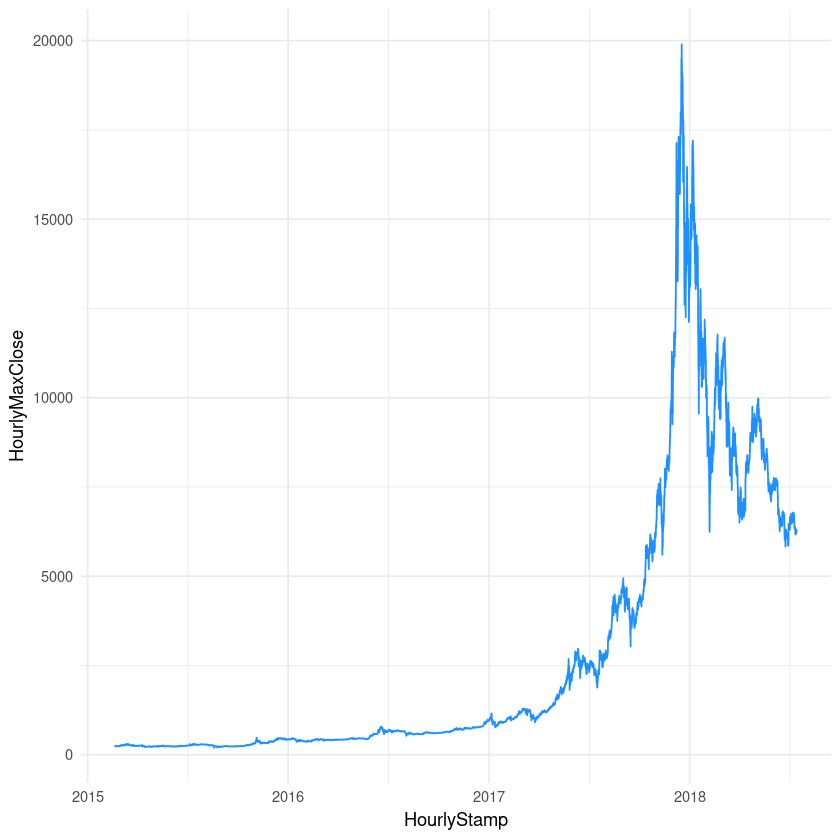

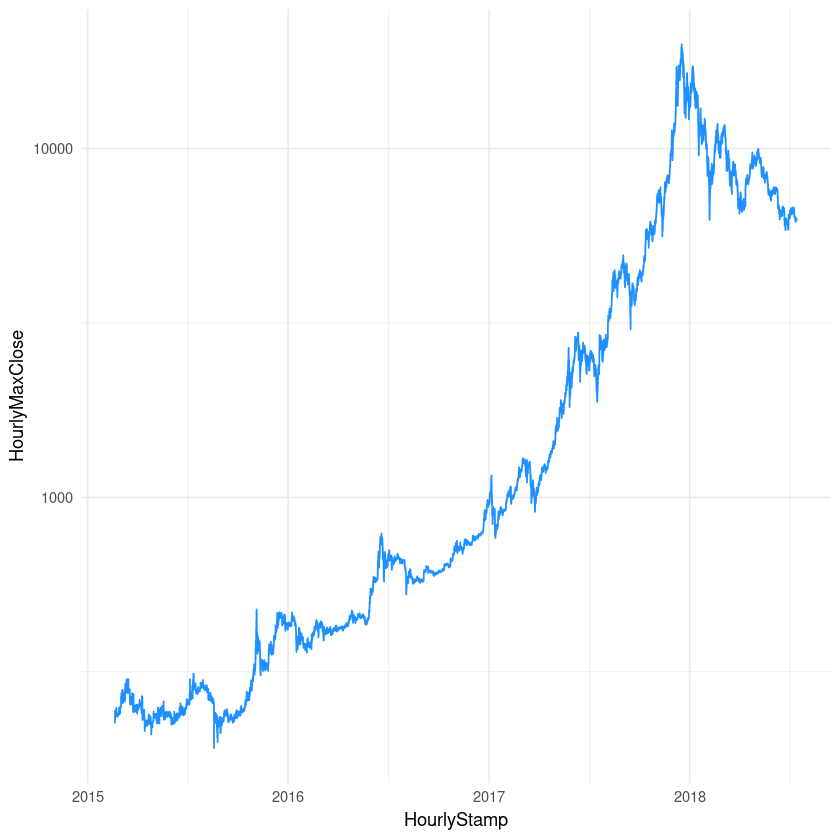

In [2]:
g <- ggplot(raw_data, aes(x = HourlyStamp, y = HourlyMaxClose)) +
    geom_line(colour = "dodgerblue") +
    theme_minimal()

print(g)
print(g + scale_y_log10())

These charts look exactly as expected - great news. Interesting to see, that while there have been large drawbacks (relative to teh peaks) in the past 3 years, none of these drawbacks have been as extended as the 2018 bear market. 

**Daily returns**  
We will calculate the % daily returns, taking the max closing price of each day.  

DailyStamp,DailyReturn
2015-02-19,0.000000000
2015-02-20,0.004098361
2015-02-21,0.000000000
2015-02-22,0.016326531
2015-02-23,-0.056220884
2015-02-24,0.020208425


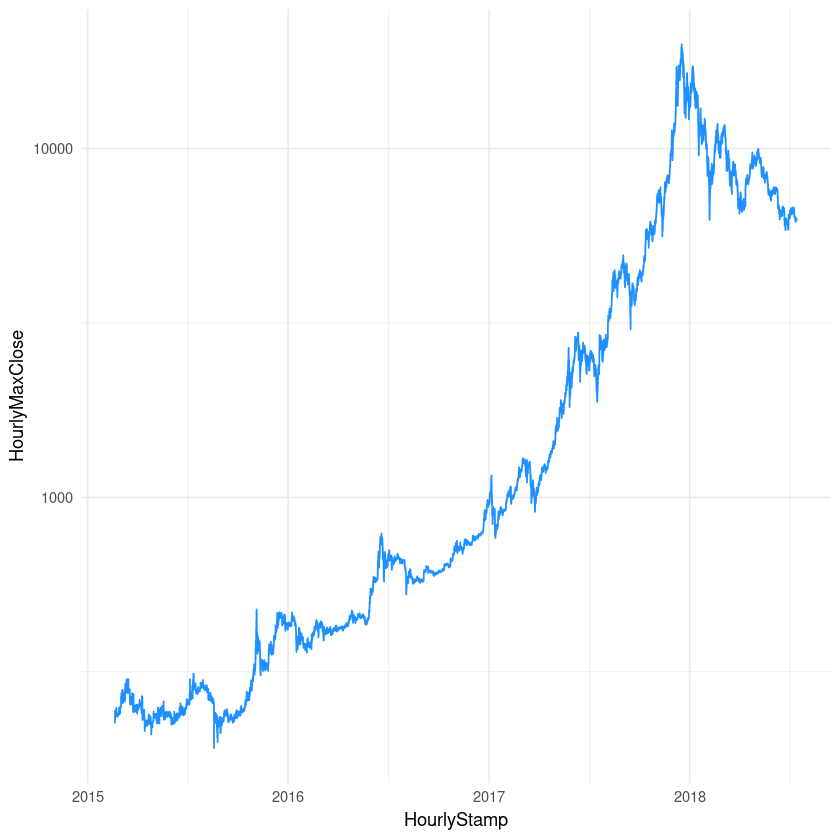

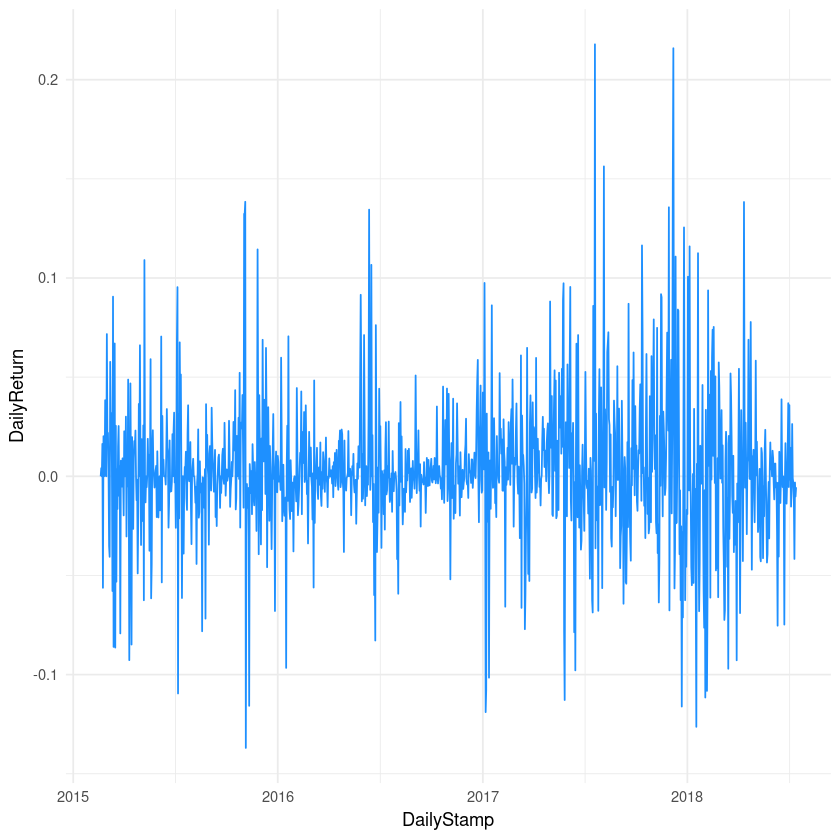

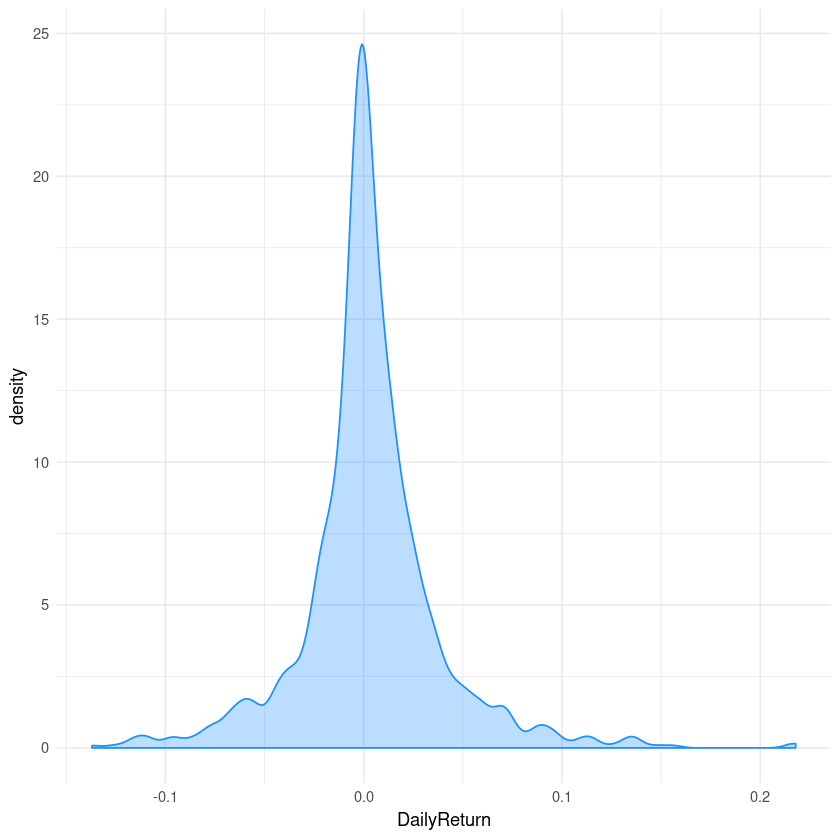

In [3]:
calculate_return <- function (a, b) {
    (b - a) / a
}
historical_periods <- unique(raw_data$DailyStamp)
daily_returns <- rbindlist(
    lapply(1:length(historical_periods), function (idx) {
        if (idx == 1) {
            data.table(DailyStamp = historical_periods[idx], 
                       DailyReturn = 0)
        } else {
            today <- raw_data[DailyStamp == historical_periods[idx], max(HourlyMaxClose)]
            yesterday <- raw_data[DailyStamp == historical_periods[idx - 1], max(HourlyMaxClose)]
            
            data.table(DailyStamp = historical_periods[idx], 
                      DailyReturn = calculate_return(yesterday, today))
        }
    })
)
head(daily_returns)

print(g + scale_y_log10())
ggplot(daily_returns, aes(x = DailyStamp, y = DailyReturn)) +
    geom_line(colour = "dodgerblue") +
    theme_minimal()
ggplot(daily_returns, aes(x = DailyReturn)) +
    geom_density(colour = "dodgerblue", fill = "dodgerblue", alpha = 0.3) +
    theme_minimal()

The daily returns look very much like the first difference (or the first moment) of the timeseries (which it is!). The distribution is quite heavy-tailed, more like a t-distribution than a Gaussian. The returns, over time, also look a lot like a random walk (which is typical of stock data), there would be a strong Bayesian prior we could put on these. I wonder how predictable it really is...???

**Future returns**  

Let's now calculate the future daily returns. These returns are the returns from day(n) -> day(n+1), day(n) -> day(n+2), ..., day(n) -> day(n+30). These will be the series we are trying to predict

Warning message in max(HourlyMaxClose):
“no non-missing arguments to max; returning -Inf”

DailyStamp,DayN,FutureReturn,FuturePrice
2015-02-19,1,0.004098361,245.000
2015-02-19,2,0.004098361,245.000
2015-02-19,3,0.020491803,249.000
2015-02-19,4,-0.036881148,235.001
2015-02-19,5,-0.017418033,239.750
2015-02-19,6,-0.017418033,239.750


Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

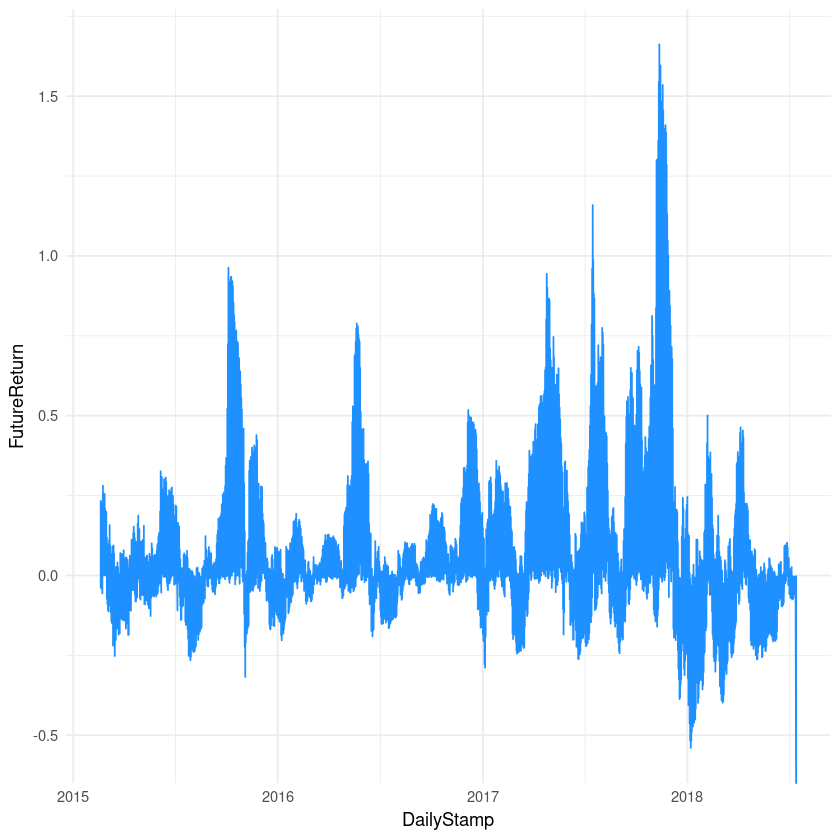

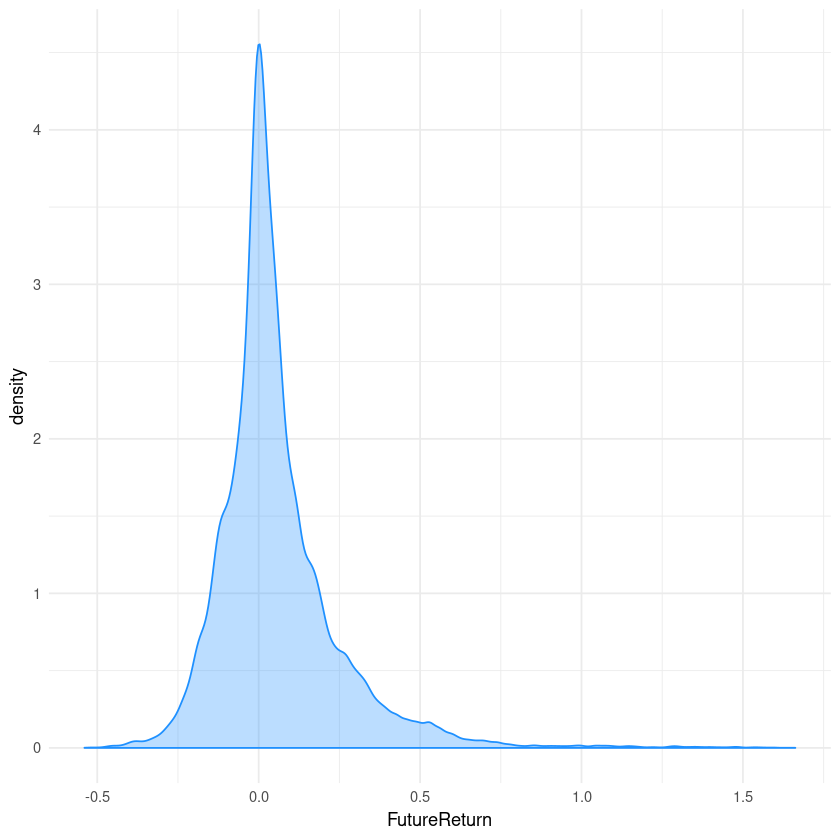

In [129]:
historical_periods <- unique(raw_data$DailyStamp)
max_periods <- length(historical_periods)
max_length <- 30

future_returns <- rbindlist(
    lapply(1:length(historical_periods), function (idx) {
        
        start <- idx + 1
        end <- ifelse(idx + max_length > max_periods, max_periods, idx + max_length)
        future_days <- historical_periods[start:end]
        
        data.table(
            DailyStamp = historical_periods[idx],
            DayN = 1:length(future_days),
            FutureReturn = unlist(lapply(future_days, function (x) {
                today <- raw_data[DailyStamp == historical_periods[idx], max(HourlyMaxClose)]
                day_n <- raw_data[DailyStamp == x, max(HourlyMaxClose)]
                
                return (calculate_return(today, day_n))
            })),
            FuturePrice = raw_data[DailyStamp %in% future_days, .(FP = max(HourlyMaxClose)), by = "DailyStamp"][, FP]
        )
    })
)
head(future_returns)

ggplot(future_returns, aes(x = DailyStamp, y = FutureReturn)) +
    geom_line(colour = "dodgerblue") +
    theme_minimal()
ggplot(future_returns, aes(x = FutureReturn)) +
    geom_density(colour = "dodgerblue", fill = "dodgerblue", alpha = 0.3) +
    theme_minimal()

The distribution of future returns looks a lot like the daily returns, but with much wider variance. This makes sense, the returns a reasonably stochastic, but they seem to be more extreme the longer that you hold the currency for. There are some very, very large returns over some of these periods. 

More interesting, the distribution of 30 day returns is right-skewed. This means, that (based on historical trading), you are more likely to win in the long-run than lose. Interesting. Look what happens, if we treat this as a generative process:

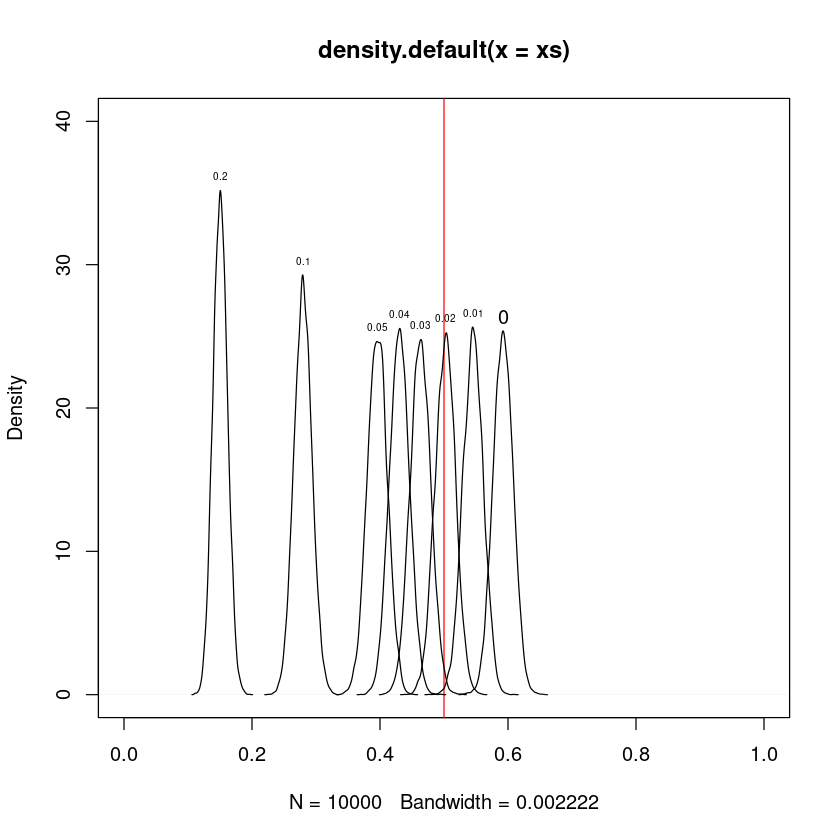

In [5]:
generate <- function (xs) sample(xs, 1000, replace = TRUE)
simulator <- function (eps) {
    sum(generate(future_returns$FutureReturn) > eps) / 1000
}
xs <- unlist(lapply(1:10000, function (x) simulator(0)))
z <- density(xs)
plot(z, xlim = c(0, 1), ylim = c(0, 40))
text(x = mean(xs), y = max(z$y + 1), label = 0.0)
abline(v=0.5, col = 'red')
                    
for (eps in c(0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2)) {
    xs <- unlist(lapply(1:10000, function (x) simulator(eps)))
    z <- density(xs)
    lines(z)
    text(x = mean(xs), y = max(z$y + 1), label = eps, cex = 0.5)
}

I don't want to specualte on this too much... but it seems that if you bought the currency and sold after 30 days, there's a 59.2% likelihood of coming out on top, >55% chance of making 1% return. The likelihood of large returns drop quickly however. 

This is the true "stochastic" likelihood of winning over 30 days and will be the baseline for our models. Our models *should outperform this baseline*, otherwise they are no better than random.

## Model One  

For our first model, we will use rolling 7 week Bitcoin data to try to predict the 30-day future returns. I am treating this as a sequence-to-sequence model which will allow us to predict multiple return horizons in one go. 

Seven weeks input data is quite a long timeframe, but I have chosen this so that we can begin to capture any weekly patterns that might exist in the trading history. The downside, is that this results in a long input sequence (approx. 1000 hourly timesteps). These timesteps will also be highly correlated. So, we will pass the input sequence through a compression layer prior to the LSTM layers.  

Let's begin by defining our model and I will wrangle the data afterwards. We will largely follow the code from here: https://keras.rstudio.com/articles/examples/lstm_seq2seq.html 

In [10]:
max_features <- 24 * 7 * 7 + 1
horizon <- 30
latent_dim <- 64

encoder_inputs <- layer_input(shape = list(NULL, max_features))
encoder <- layer_lstm(units = latent_dim, dropout = 0.2, recurrent_dropout = 0.2, return_state = TRUE)
encoder_results <- encoder_inputs %>% encoder
encoder_states <- encoder_results[2:3]

decoder_inputs <- layer_input(shape = list(NULL, horizon))
decoder_lstm <- layer_lstm(units = latent_dim, return_sequences = TRUE, return_state = TRUE, stateful = FALSE)
decoder_results <- decoder_inputs %>% decoder_lstm(initial_state = encoder_states)
decoder_dense <- layer_dense(units = horizon, activation = "sigmoid")
decoder_outputs <- decoder_dense(decoder_results[[1]])

model <- keras_model(inputs = list(encoder_inputs, decoder_inputs),
                    outputs = decoder_outputs)

model %>% compile(optimizer = "adam", loss = "mse")

Great, now that we have the model setup, I can wrangle the dataset to flow through it:

[1] 1213


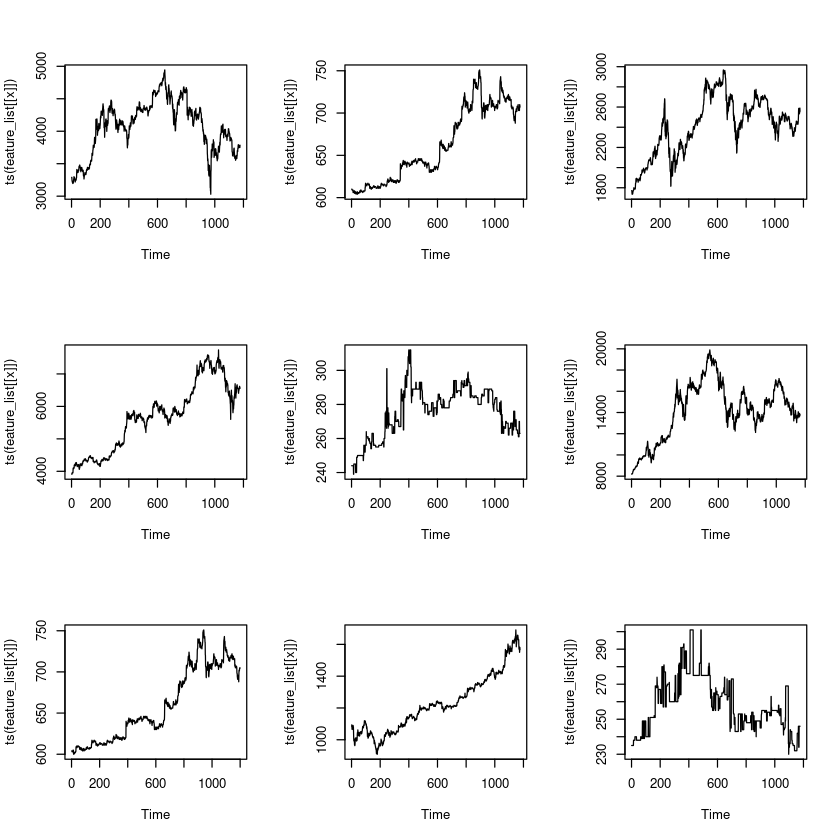

In [21]:
# will ignore the first 30 days, as there are limited history for these days and move forwards from there.
n_periods <- length(historical_periods)

# the following creates a timeseries list...
feature_list <- sapply(sort(historical_periods)[30:n_periods], function (day) {
    
    begin <- day - (7 * 7 * 60 * 60 * 24)
    raw_data[DailyStamp > begin & DailyStamp <= day, 
            .(CounterValue = floor(max(HourlyMaxClose) + 0.5)), by = "HourlyStamp"][, CounterValue]
})
print(length(feature_list))
par(mfrow = c(3, 3))
for (x in sample(length(feature_list), 9)) {
    plot(ts(feature_list[[x]]))
}
par(mfrow = c(1, 1))

Right, so we've got 1213 input sequences. Let's create the output sequences...

[1] 1213
[1] 1213
[1] 1213


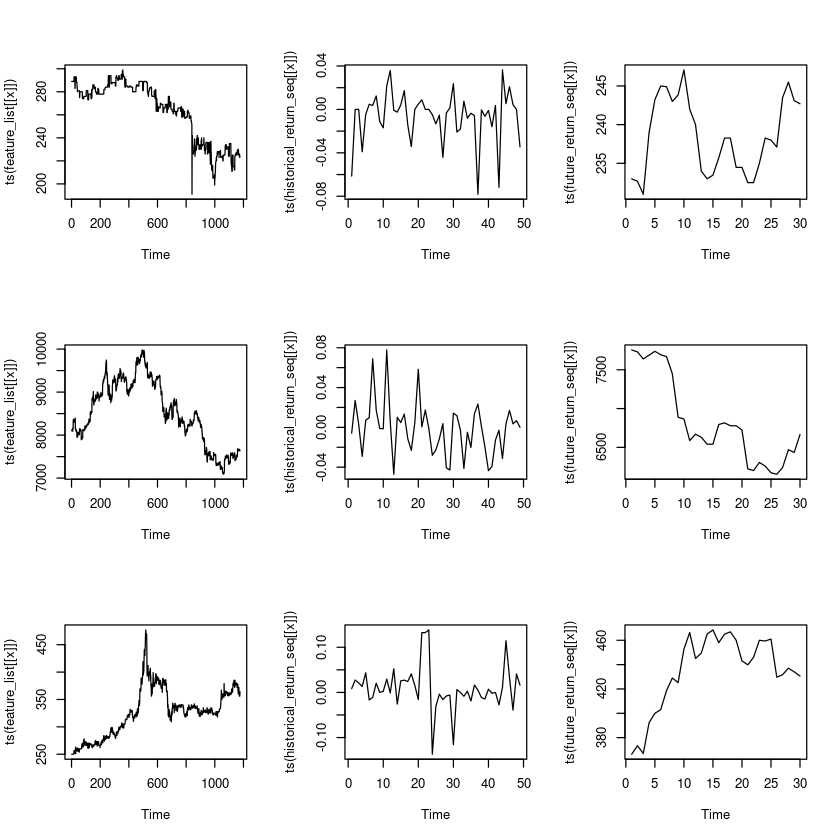

In [130]:
historical_return_seq <- list()
future_return_seq <- list()
for (x in 1:length(sort(historical_periods)[30:n_periods])) {
    
    day <- historical_periods[30:n_periods][x]
    begin_history <- day - (7 * 7 * 60 * 60 * 24)
    end_future <- day + (30 * 60 * 60 * 24)
    
    historical_return_seq[[x]] <- daily_returns[DailyStamp >= begin_history & DailyStamp < day, DailyReturn]
    future_return_seq[[x]] <- future_returns[DailyStamp == day, FuturePrice]
}

print(length(feature_list))
print(length(historical_return_seq))
print(length(future_return_seq))

par(mfrow = c(3, 3))
for (x in sample(length(feature_list), 3)) {

    plot(ts(feature_list[[x]]))
    plot(ts(historical_return_seq[[x]]))
    plot(ts(future_return_seq[[x]]))  
}
par(mfrow = c(1, 1))

Now that I have three lists, we need to put it into arrays for the model...

In [134]:
max_features <- max(sapply(feature_list, length))


# Array dimensions are: (nsamples, dimensions of timeseries, timeseries values)
# So for me: (samples, 1 (i.e. univariate), values)
# see the manual: https://keras.rstudio.com/reference/layer_lstm.html 
encoder_input_data <- array(0, dim = c(length(feature_list),1, max_features))
decoder_input_data <- array(0, dim = c(length(feature_list), 1, 30))
decoder_output_data <- array(0, dim = c(length(feature_list), 1, 30))

for (i in 1:length(feature_list)) {
   
    xs <- feature_list[[i]]
    zs <- rep(0, maxfeatures)
    lower <- min(xs)
    upper <- max(xs)
    zs[(max_features - length(xs) + 1):max_features] <- (xs - lower) / (upper - lower)

    encoder_input_data[i,, 1:max_features] <- zs
    
    xs <- future_return_seq[[i]]
    zs <- rep(0, 30)
    zs[1:length(xs)] <- (xs - lower) / (upper - lower)
    
    decoder_input_data[i,, 1:30] <- zs
    decoder_output_data[i,, 1:30] <- zs
}

Let's fit the model

In [137]:

horizon <- 30
latent_dim <- 32

encoder_inputs <- layer_input(shape = list(NULL, max_features))
encoder <- layer_lstm(units = latent_dim, dropout = 0.5, recurrent_dropout = 0.5, return_state = TRUE)
encoder_results <- encoder_inputs %>% encoder
encoder_states <- encoder_results[2:3]

decoder_inputs <- layer_input(shape = list(NULL, horizon))
decoder_lstm <- layer_lstm(units = latent_dim, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = TRUE, return_state = TRUE, stateful = FALSE)
decoder_results <- decoder_inputs %>% decoder_lstm(initial_state = encoder_states)
decoder_dense <- layer_dense(units = horizon, activation = "relu")
decoder_outputs <- decoder_dense(decoder_results[[1]])

model <- keras_model(inputs = list(encoder_inputs, decoder_inputs),
                    outputs = decoder_outputs)

model %>% compile(optimizer = "adam", loss = "mse")
summary(model)


________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_40 (InputLayer)     (None, None, 1199 0                                   
________________________________________________________________________________
input_41 (InputLayer)     (None, None, 30)  0                                   
________________________________________________________________________________
lstm_38 (LSTM)            [(None, 32), (Non 157696   input_40[0][0]             
________________________________________________________________________________
lstm_39 (LSTM)            [(None, None, 32) 8064     input_41[0][0]             
                                                     lstm_38[0][1]              
                                                     lstm_38[0][2]              
________________________________________________________________________________
dense_19 (Dense)          (N

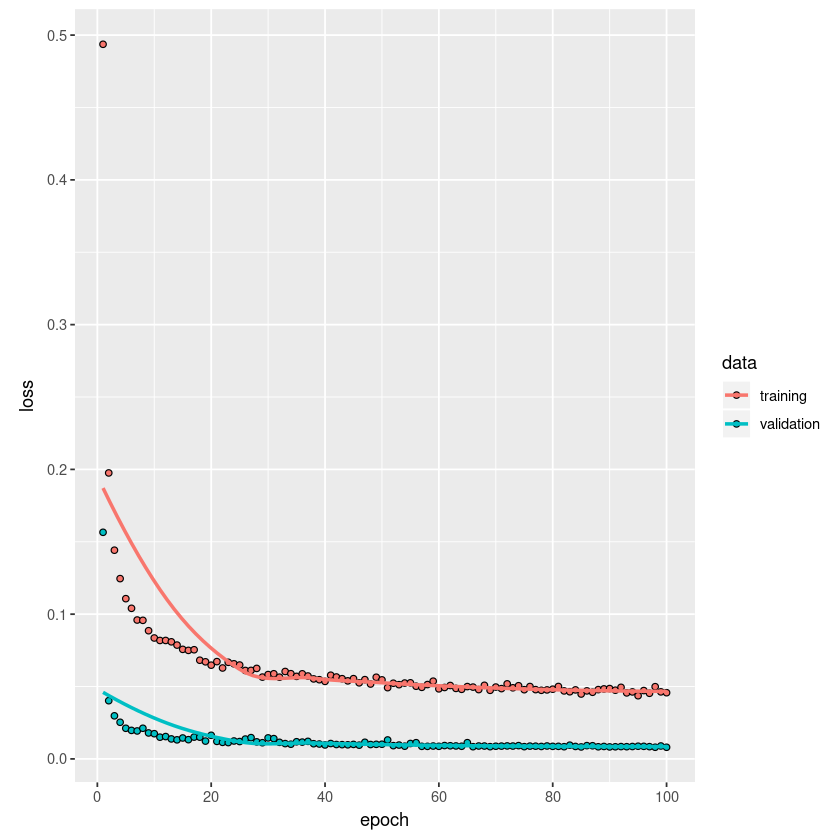

In [138]:
history <- model %>% fit( list(encoder_input_data, decoder_input_data), decoder_output_data,
               batch_size=12,
               epochs=100,
               validation_split=0.1)
plot(history)

That's really interesting - it isn't learning. It is overfitting something wicked, but it isn't predicting anything, looking at the validation set.

Ahha! I has learned something :) I changed the target sequence to be the future price, then I used min-max scaling (lower = min(input seq), upper = max(input seq)) to scale both the input and target sequences. This is great. There's something to follow up on here now.

[1] "output tokens"
, , 1

         [,1]
[1,] 0.315922

, , 2

          [,1]
[1,] 0.2749186

, , 3

         [,1]
[1,] 0.196012

, , 4

          [,1]
[1,] 0.1481818

, , 5

          [,1]
[1,] 0.1061431

, , 6

           [,1]
[1,] 0.07261051

, , 7

           [,1]
[1,] 0.05037505

, , 8

           [,1]
[1,] 0.05078494

, , 9

           [,1]
[1,] 0.05115524

, , 10

           [,1]
[1,] 0.03335488

, , 11

           [,1]
[1,] 0.01422503

, , 12

           [,1]
[1,] 0.01654326

, , 13

     [,1]
[1,]    0

, , 14

     [,1]
[1,]    0

, , 15

     [,1]
[1,]    0

, , 16

     [,1]
[1,]    0

, , 17

     [,1]
[1,]    0

, , 18

     [,1]
[1,]    0

, , 19

     [,1]
[1,]    0

, , 20

     [,1]
[1,]    0

, , 21

     [,1]
[1,]    0

, , 22

     [,1]
[1,]    0

, , 23

     [,1]
[1,]    0

, , 24

     [,1]
[1,]    0

, , 25

     [,1]
[1,]    0

, , 26

     [,1]
[1,]    0

, , 27

     [,1]
[1,]    0

, , 28

     [,1]
[1,]    0

, , 29

     [,1]
[1,]    0

, , 30

     [,1]


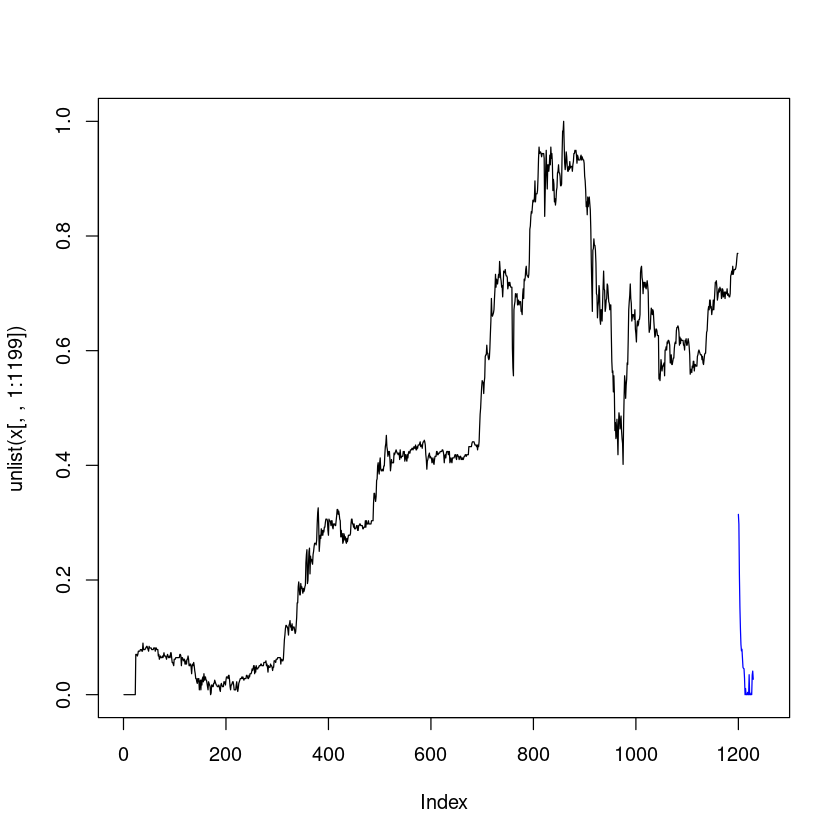

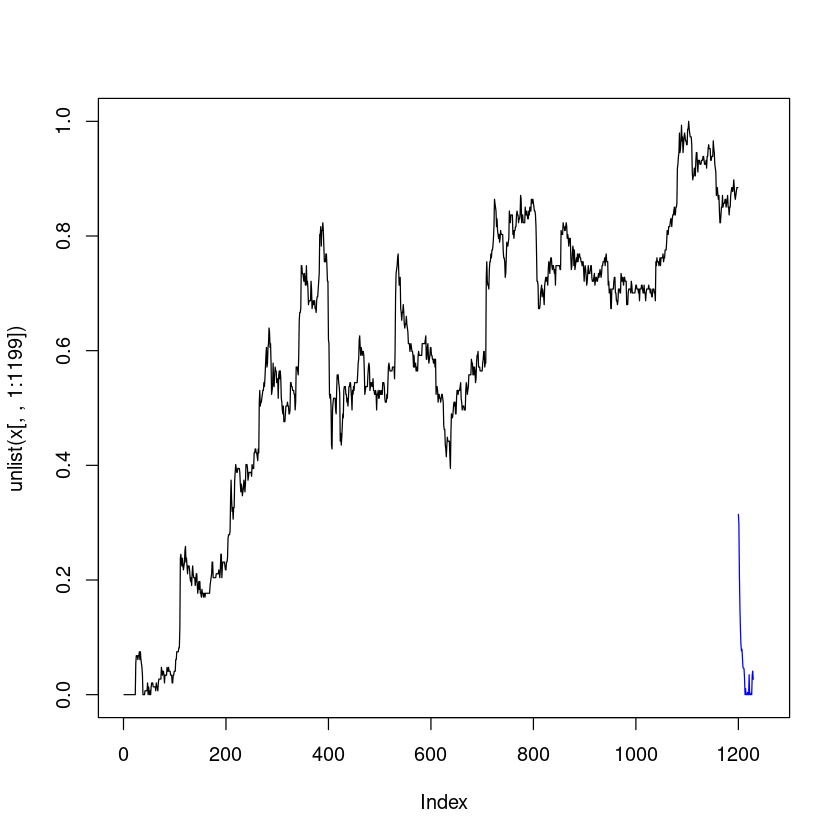

In [168]:
## Here's the drill:
## 1) encode input and retrieve initial decoder state
## 2) run one step of decoder with this initial state
## and a "start of sequence" token as target.
## Output will be the next target token
## 3) Repeat with the current target token and current states

## Define sampling models
encoder_model <-  keras_model(encoder_inputs, encoder_states)
decoder_state_input_h <- layer_input(shape=latent_dim)
decoder_state_input_c <- layer_input(shape=latent_dim)
decoder_states_inputs <- c(decoder_state_input_h, decoder_state_input_c)
decoder_results <- decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states  <- decoder_results[2:3]
decoder_outputs <- decoder_dense(decoder_results[[1]])
decoder_model   <- keras_model(
  inputs  = c(decoder_inputs, decoder_states_inputs),
  outputs = c(decoder_outputs, decoder_states))


decode_sequence <- function(input_seq) {
  ## Encode the input as state vectors.
  states_value <- predict(encoder_model, input_seq)
  
  ## Generate empty target sequence of length 1.
  target_seq <- array(0, dim=c(1, 1, 30))
  
  ## Sampling loop for a batch of sequences
  ## (to simplify, here we assume a batch of size 1).
  stop_condition = FALSE
  decoded_sentence = ''
  maxiter = 2
  niter = 1
  while (!stop_condition && niter < maxiter) {
    
    ## output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    decoder_predict <- predict(decoder_model, c(list(target_seq), states_value))
    output_tokens <- decoder_predict[[1]]
    print("output tokens")
      print(output_tokens)
    #print(output_tokens)
    ## Update the target sequence (of length 1).
    ## target_seq = np.zeros((1, 1, num_decoder_tokens))
   # target_seq[1, 1, ] <- 0
    #target_seq[1, 1, sampled_token_index] <- 1.
    target_seq[1, 1, niter] <- output_tokens[,,1]
      print("target seq")
      print(target_seq)
    ## Update states
    h <- decoder_predict[[2]]
    c <- decoder_predict[[3]]
    states_value = list(h, c)
    niter <- niter + 1
  }    
  return(decoded_sentence)
}

for (seq_index in sample(length(feature_list), 2)) {
  ## Take one sequence (part of the training test)
  ## for trying out decoding.
  input_seq = encoder_input_data[seq_index,,,drop=FALSE]
  decoded_sentence = decode_sequence(input_seq)
  
    x <- encoder_input_data[seq_index, , , drop =FALSE]
    plot(unlist(x[,,1:1199]), type = "l", xlim = c(1,1250))
    lines(1200:1229, decoder_predict[[1]], col='blue')
}

-0.2724274,0.4196136,0.08558567,-0.1228227,-0.2088756,-0.09259257,-0.02117502,-0.2116111,0.1442567,0.08637517,⋯,0.4313777,0.09162603,0.1795793,0.2201258,0.1623809,0.08402713,0,0.03438973,-0.07704556,0.1670497
-0.7788934,0.5177678,0.3014422,-0.2266734,-0.7222874,-0.203319,-0.03999522,-0.4954489,0.374991,0.3549645,⋯,0.4615881,0.3724799,0.398041,0.6494706,0.3472198,0.1401038,0,0.09435177,-0.2701668,0.724201


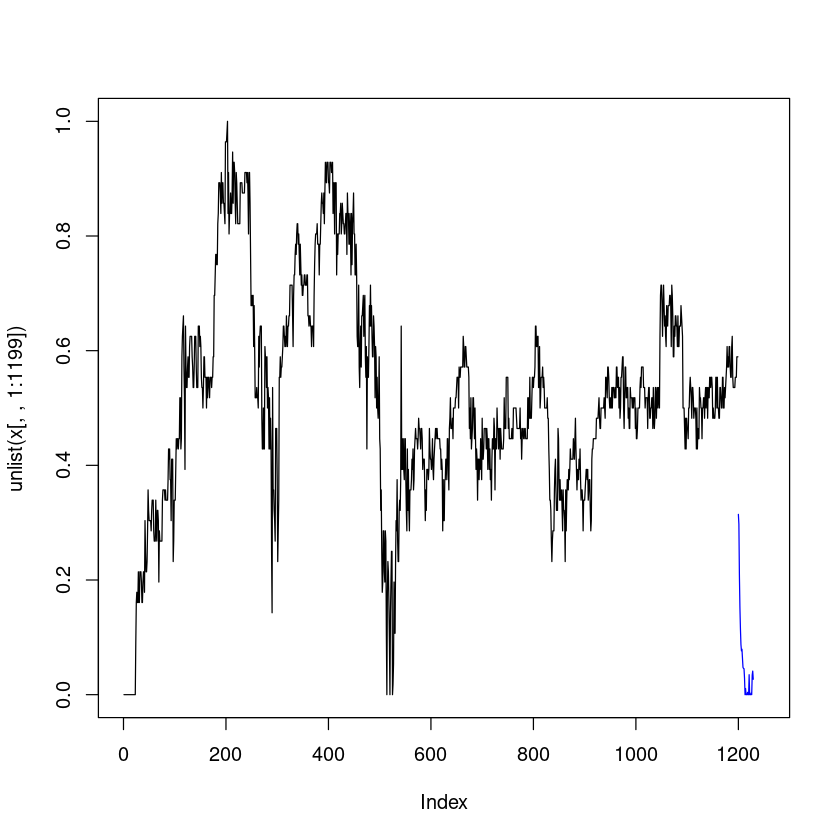

In [161]:


x <- encoder_input_data[sample(length(feature_list), 1), , , drop =FALSE]


target_seq <- array(0, dim=c(1, 1, 30))
states_value <- predict(encoder_model, x)
decoder_predict <- predict(decoder_model, c(list(target_seq), states_value))
decoder_predict

plot(unlist(x[,,1:1199]), type = "l", xlim = c(1,1250))
lines(1200:1229, decoder_predict[[1]], col='blue')

## References  

Palangi, H., Deng, L., Shen, Y., Gao, J., He, X., Chen, J., ... & Ward, R. (2016). Deep sentence embedding using long short-term memory networks: Analysis and application to information retrieval. IEEE/ACM Transactions on Audio, Speech and Language Processing (TASLP), 24(4), 694-707.

Zhu, Y., Kiros, R., Zemel, R., Salakhutdinov, R., Urtasun, R., Torralba, A., & Fidler, S. (2015). Aligning books and movies: Towards story-like visual explanations by watching movies and reading books. In Proceedings of the IEEE international conference on computer vision (pp. 19-27).